# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [30]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Inspection and Preparation

In [79]:
# load in the data
azdias = pd.read_csv('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/azdias.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Findings:
1. After comparing the azdias dataset and the 'DIAS Information Levels - Attributes 2017.xlsx' file, it seems some columns in the dataset don't have a defined meaning from the file. Columns that don't show up in the attributes file will be dropped as we don't know the column meaning. 
2. Upon reading the 'DIAS Attributes - Values 2017.xlsx' file, it seems the data has already been grouped, with missing value coded as a specific non-missing value. These coded missing values will be replaced by np.nan. 
3. Since data has already been grouped, there wouldn't be any outliers.

In [2]:
# cols_ref is list of attributes whose meanings have been provided in existing file 'DIAS Information Levels - Attributes 2017.xlsx'
# nonvalue_map is list of the 'missing' values that each attribute currently has based on existing file 'DIAS Attributes - Values 2017.xlsx'
cols_ref = pd.read_excel('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/DIAS Information Levels - Attributes 2017.xlsx', usecols="C", skiprows=1) 
nanvalue_map = pd.read_excel('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone//DIAS Attributes - Values 2017_unknown.xlsx',  usecols="A:B")

In [3]:
# change the dataframe to a dictionary, with attributes as the key, 'missing' values as the value
nanvalue_map = nanvalue_map.set_index('Attribute').T.to_dict('list')
for k,v in nanvalue_map.items():
    if type(nanvalue_map[k][0])==str:
        nanvalue_map[k] = list(map(int, nanvalue_map[k][0].split(', ')))

In [23]:
# check character value columns
azdias.select_dtypes(include=['O']).columns 

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')

In [24]:
# attribute CAMEO_DEU_2015 has a value of 'XX' that 
# doesn't seem to have a meaning based on the provided value-meaning file
azdias.CAMEO_DEU_2015.value_counts(dropna=False)

NaN    98979
6B     56672
8A     52438
4C     47819
2D     35074
3C     34769
7A     34399
3D     34307
8B     33434
4A     33155
8C     30993
9D     28593
9B     27676
9C     24987
7B     24503
9A     20542
2C     19422
8D     17576
6E     16107
2B     15486
5D     14943
6C     14820
2A     13249
5A     12214
1D     11909
1A     10850
3A     10543
5B     10354
5C      9935
7C      9065
4B      9047
4D      8570
3B      7160
6A      6810
9E      6379
6D      6073
6F      5392
7D      5333
4E      5321
1E      5065
7E      4633
1C      4317
5F      4283
1B      4071
5E      3581
XX       373
Name: CAMEO_DEU_2015, dtype: int64

In [25]:
# attribute CAMEO_DEUG_2015 has a value of 'X' that 
# doesn't seem to have a meaning based on the provided value-meaning file
azdias.CAMEO_DEUG_2015.value_counts(dropna=False)

NaN    98979
8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [28]:
# attribute OST_WEST_KZ is without abnormal values
azdias.OST_WEST_KZ.value_counts(dropna=False)

W      629528
O      168545
NaN     93148
Name: OST_WEST_KZ, dtype: int64

In [30]:
# check if the two attributes with abnormal values already exist in the missing
# value dictionary nanvalue_map
for col in ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']:
    if col in nanvalue_map.keys():
        print(col)

CAMEO_DEUG_2015


In [4]:
# add the abnormal values 'XX' and 'X' to the missing value dictionary nanvalue_map
nanvalue_map['CAMEO_DEU_2015'] = ['XX']
nanvalue_map['CAMEO_DEUG_2015'].append('X')

### Data processing

In [5]:
# function to drop columns whose meanings were not provided and
# replace the 'missing' values to actual nan value
def replacenan_lean(df):
    '''
    input:
    df - dataframe that needs to be processed
    
    output:
    df_replacenan - new dataframe with the unknown columns dropped 
                    and nan as missing values
    '''
    df_replacenan = df.copy(deep=True)
    for col in df_replacenan.columns:
        if col not in cols_ref.Attribute.values:
            df_replacenan.drop([col], axis=1, inplace=True)
            
    for k,v in nanvalue_map.items():
        if k in df_replacenan.columns:
            df_replacenan.loc[df_replacenan[k].isin(nanvalue_map[k]), k] = np.nan
    
    return df_replacenan

In [80]:
# drop columns and replace mising values of azdias
azdias_lean = replacenan_lean(azdias)

In [9]:
# high level peek at the data
azdias_lean.head(5)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,11.0,0.0,2.0,0.0,3.0,6.0,8A,8.0,...,1.0,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,3.0,2.0,4C,4.0,...,4.0,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,2.0,4.0,2A,2.0,...,4.0,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,4.0,2.0,6B,6.0,...,7.0,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [6]:
# function to either drop columns with a high percentage of nan value 
# or replace nan value with most frequent value for columns with a low percentage of nan value
# also plot a bar graph of nan value percentage for attributes
def nanvalue_fix(df, pct_graph, drop_pct, name='dfname'):
    '''
    input:
    df - dataframe that needs to be processed
    pct_graph - percentage cutoff of nan value above which columns will show on the bar graph
                for instance, pct_graph=0.3 means columns with 30%+ of nan values will be plotted
    drop_pct - percentage cutff of nan value above which columns will be dropped
    name - dataframe name to show on the bar graph
    
    output:
    df_fix - dataframe whose nan values have been taken care of
    '''
    nanvalue_pct = df.isnull().mean().sort_values(ascending=False)
    
    nanvalue_pct[nanvalue_pct>pct_graph].plot.bar(figsize=(25,10))
    plt.ylabel('% of missing values')
    plt.xlabel('Variables', fontsize=1)
    plt.title('Missing Value Percentage-'+name, fontsize=20)
    
    df_fix = df.copy(deep=True)
    for index, value in nanvalue_pct.items():
        if value > drop_pct:
            df_fix.drop([index], axis=1, inplace=True)
        elif value > 0:
            df_fix[index].fillna(df_fix[index].value_counts().index[0], inplace=True)
    
    df_fix.CAMEO_DEUG_2015 = df_fix.CAMEO_DEUG_2015.astype('int')
    return df_fix

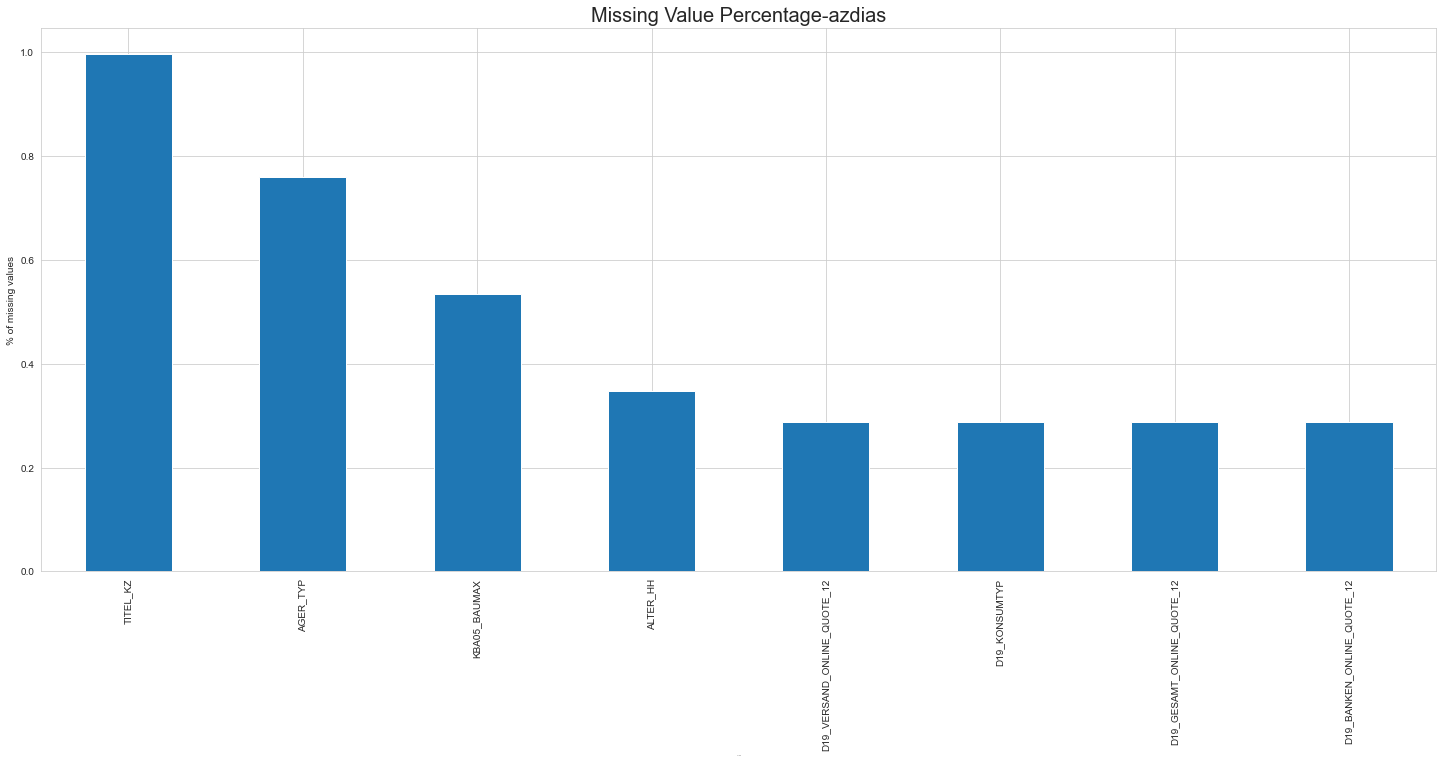

In [81]:
# process the nan values of azdias data and plot nan value percentage
azdias_clean = nanvalue_fix(azdias_lean, 0.2, 0.3, 'azdias')

In [68]:
# recheck character value columns
azdias_clean.select_dtypes(include=['O']).columns 

Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')

#### preprocessing: encoding catagorical variables and  scaling the numeric variables
since data fields have been grouped, it might be too aggressive to assume a normal distribution for every numeric variables, so MinMaxScaler() (Normalization) has been used to scale numeric variables instead of Standardization scaling. 

In [7]:
# preprocess the data before modeling, including encoding for catagorical columns and scaling numerical columns
# using Normalization. 
def preprocess(df):
    '''
    input:
    df - dataframe to be pre-processed
    
    output:
    df_encd - dataframe whose catagorical columns have been encoded 
              and numerical columns Normalized
    '''
    df_encd = pd.get_dummies(df)
    normscaler = MinMaxScaler()
    
    numeric_col = [col for col in df.columns if col not in ('CAMEO_DEU_2015', 'OST_WEST_KZ')]
    df_encd[numeric_col] = normscaler.fit_transform(df_encd[numeric_col])
    return df_encd

In [82]:
# preprocess the azdias data
azdias_encd = preprocess(azdias_clean)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [70]:
# there are more than 200 attributes. PCA is used to reduce dimention.
pca = PCA()
pca.fit(azdias_encd)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance')

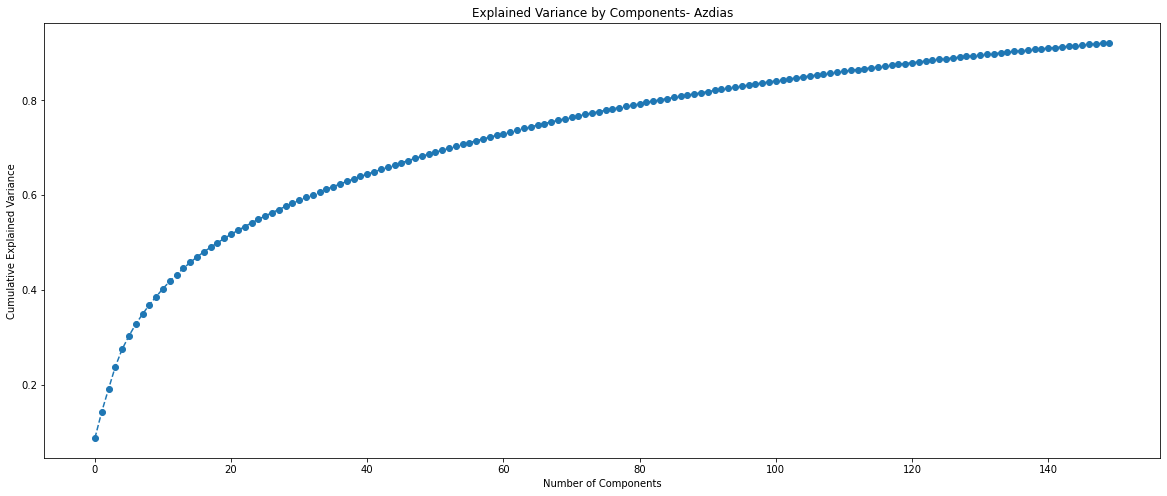

In [71]:
# Find the appropriate number of Components by plottig the Cumulative Explained Variance against number of Components
plt.figure(figsize = (20,8))
plt.plot(pca.explained_variance_ratio_[:150].cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components- Azdias')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

#### The explained variance obviously increases with the increase of number of components. However, we might not want to choose too many components, which is against the purpose of dimentionality reduction. 80% of variance being explained is generally suffient. Based on the graph above, 85 components seem to be good enough, and after 85 components, the increase of explained variance is minimal and slow

In [83]:
# fit and transform the data using PCA with 85 components
pca = PCA(n_components = 85,random_state=19)
pca.fit(azdias_encd)
pca_azdias = pca.transform(azdias_encd)
var_explained = pca.explained_variance_ratio_.sum()
print("Using {} components, we can explain {}% of the variability in the original data.".format(85,var_explained))

Using 85 components, we can explain 0.8017398737295076% of the variability in the original data.


In [73]:
# fit the PCA transformed data to a list of #clusters in K-Means, and collect the sum of errors
wcss = []
for i in range(1, 10):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 19)
    kmeans_pca.fit(pca_azdias)
    wcss.append(kmeans_pca.inertia_)

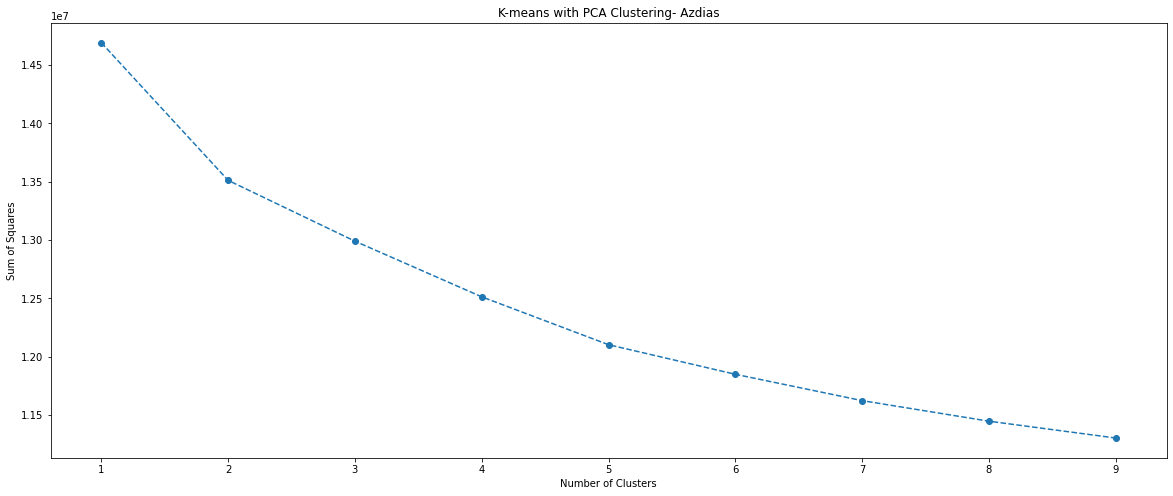

In [74]:
# plot the sum of squares against number of clusters
plt.figure(figsize = (20,8))
plt.plot(range(1, 10), wcss, marker = 'o', linestyle = '--')
plt.title('K-means with PCA Clustering- Azdias')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares')
plt.show()

#### Usually the elbow rule is used to choose a cluster number. the graph above seems to have an elbow at 2 and a milder elbow at 5. so cluster number 5 is picked.

In [13]:
# fit data in K-Means with 5 clusters
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 19)
kmeans_pca.fit(pca_azdias)

KMeans(n_clusters=5, random_state=19)

In [76]:
# concatenate the pca transformed data with the original dataframe
azdias_kmeans = pd.concat([azdias_encd.reset_index(drop = True), pd.DataFrame(pca_azdias)], axis = 1)
# prepare a list of column names for the 85 pca components
col_names = []
for i in range(85):
    col_names.append('Component'+str(i+1))

In [77]:
# update the column names for the pca components, and add the kmeans cluster output to the dataframe from previous step
azdias_kmeans.columns.values[-85:] = col_names
azdias_kmeans['KmeansSeg'] = kmeans_pca.labels_

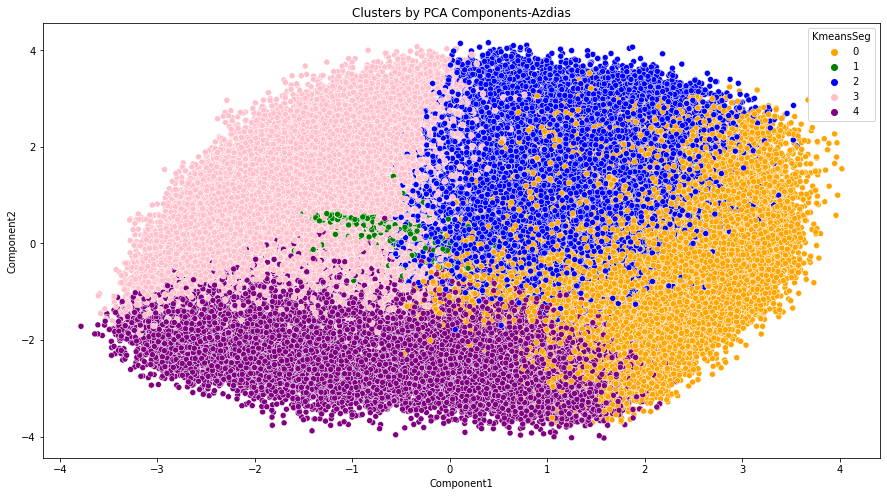

In [78]:
# visualize the five clusters by the two main pca components
plt.figure(figsize = (15, 8))
sns.color_palette("Set2")
sns.scatterplot(x = azdias_kmeans['Component1'], y = azdias_kmeans['Component2'], hue = azdias_kmeans['KmeansSeg'],
               palette = ['orange', 'green', 'blue', 'pink', 'purple'])
plt.title('Clusters by PCA Components-Azdias')
plt.show()

### Apply the PCA and Kmeans model to customers dataset

In [14]:
# read in the customers data
customers = pd.read_csv('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/customers.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
#drop columns and replace mising values
customers_lean = replacenan_lean(customers)

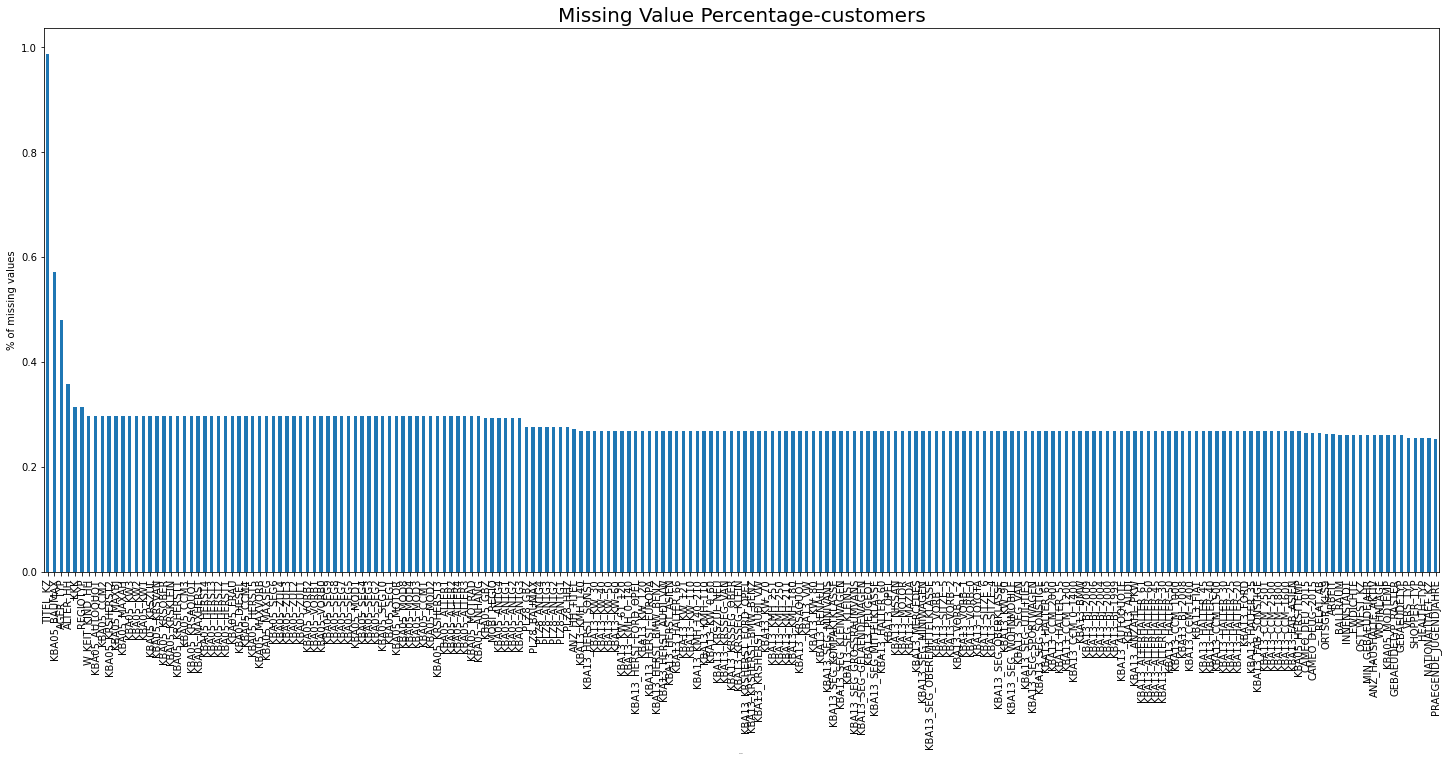

In [16]:
# process the nan values and plot nan value percentage
customers_clean = nanvalue_fix(customers_lean, 0.25, 0.35, 'customers')

In [80]:
customers_clean.select_dtypes(include=['O']).columns 

Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')

In [17]:
# preprocess the customers data
customers_encd = preprocess(customers_clean)

In [18]:
# transform customers data using pca
pca_customers = pca.transform(customers_encd)

In [19]:
# predict the customers data using kmeans
kmeans_customers_predict = kmeans_pca.predict(pca_customers)

In [21]:
# combine original customers data with pca transformed data and kmeans output
customers_kmeans = pd.concat([customers_encd.reset_index(drop = True), pd.DataFrame(pca_customers)], axis = 1)
customers_kmeans.columns.values[-85:] = col_names
customers_kmeans['KmeansSeg'] = kmeans_customers_predict

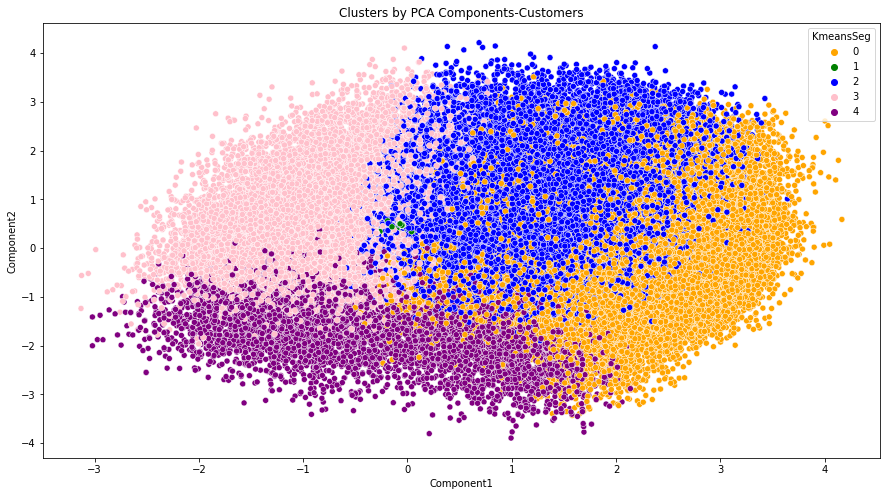

In [86]:
# visualize the five clusters by the two main pca components
plt.figure(figsize = (15, 8))
sns.color_palette("Set2")
sns.scatterplot(x = customers_kmeans['Component1'], y = customers_kmeans['Component2'], hue = customers_kmeans['KmeansSeg'],
               palette = ['orange', 'green', 'blue', 'pink', 'purple'])
plt.title('Clusters by PCA Components-Customers')
plt.show()

### Compare the kmeans results between azdias data and customers data

In [94]:
# get the percentage of each kmeans clusters in azdias data  
azdias_seg = azdias_kmeans.groupby('KmeansSeg')['Component1'].count().rename("azdias_Seg_Pct").transform(lambda x: x/x.sum())

In [95]:
# get the percentage of each kmeans clusters in customers data
customers_seg = customers_kmeans.groupby('KmeansSeg')['Component1'].count().rename("customers_Seg_Pct").transform(lambda x: x/x.sum())

In [99]:
# combine the two percentage data together for visualization purpose
combined_seg = pd.concat([azdias_seg, customers_seg], axis=1)
combined_seg.reset_index(inplace=True)

In [101]:
azdias_seg

KmeansSeg
0    0.205166
1    0.103737
2    0.273172
3    0.285599
4    0.132325
Name: azdias_Seg_Pct, dtype: float64

### It might be interesting to know: within each cluster, what would the percentage of customers be?
Within each cluster, the number of customers from that cluster/number of total population from that cluster =
                       (percentage of that cluster in customers/percentage of that cluster in total population) * a constant                                                                                                                                                           
The constant here is the record count of customer data/the record count of azdias data

In [103]:
# caculate the percentage of customers wihin each cluster.
# for instance, cluster no.1 contains 44.6% customers and 55.4% non-customers
combined_seg2 = (len(customers_kmeans)/len(azdias_kmeans))*customers_seg/azdias_seg
combined_seg2

KmeansSeg
0    0.279412
1    0.446216
2    0.303836
3    0.074985
4    0.053006
dtype: float64

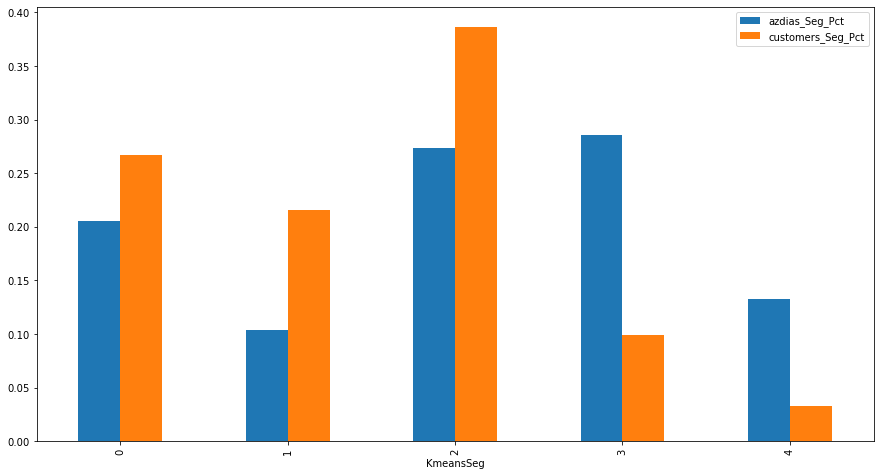

In [100]:
# plot the percentage of each clusters for both azdias data and customers data
combined_seg.plot(x="KmeansSeg", y=["azdias_Seg_Pct", "customers_Seg_Pct"], kind="bar",figsize=(15,8))
plt.show()

### Summary from segmentation results: 
1. based on the graph above, we have higher percentage of datapoints from cluster no.2 and no.3 in azdias dataset, with cluster no.1 as the lowest. In customers dataset, cluster no.2 and no.0 have high percentage and the lowest percentage is from cluster no.4

2. based on the percentage of customers within each cluster (combined_seg2 data), cluster no.1 and no.2 have highest customer percentage. In general population, we might want to target sub-population from cluster no.1 and no.2 in future marketing campaigns as there may be a better chance that the campaigns actually reach a potencial customer.

3. Assuming the azdias dataset is a good representation of the general population, we have the most people from cluster no.2 in general population. And cluster no.2 also has relatively high customer percentage. Thus, cluster no.2 could be the priority in future marketing efforts if given limited budget and time.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [8]:
# read in data
mailout_train = pd.read_csv('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/mailout_train.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
y = mailout_train['RESPONSE']

In [39]:
# check the dependent variable
y.RESPONSE.value_counts(dropna=False, normalize=True)

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

### It looks like the the dependent variable is highly unbalanced

In [10]:
#drop columns and replace mising values
mailout_lean = replacenan_lean(mailout_train)

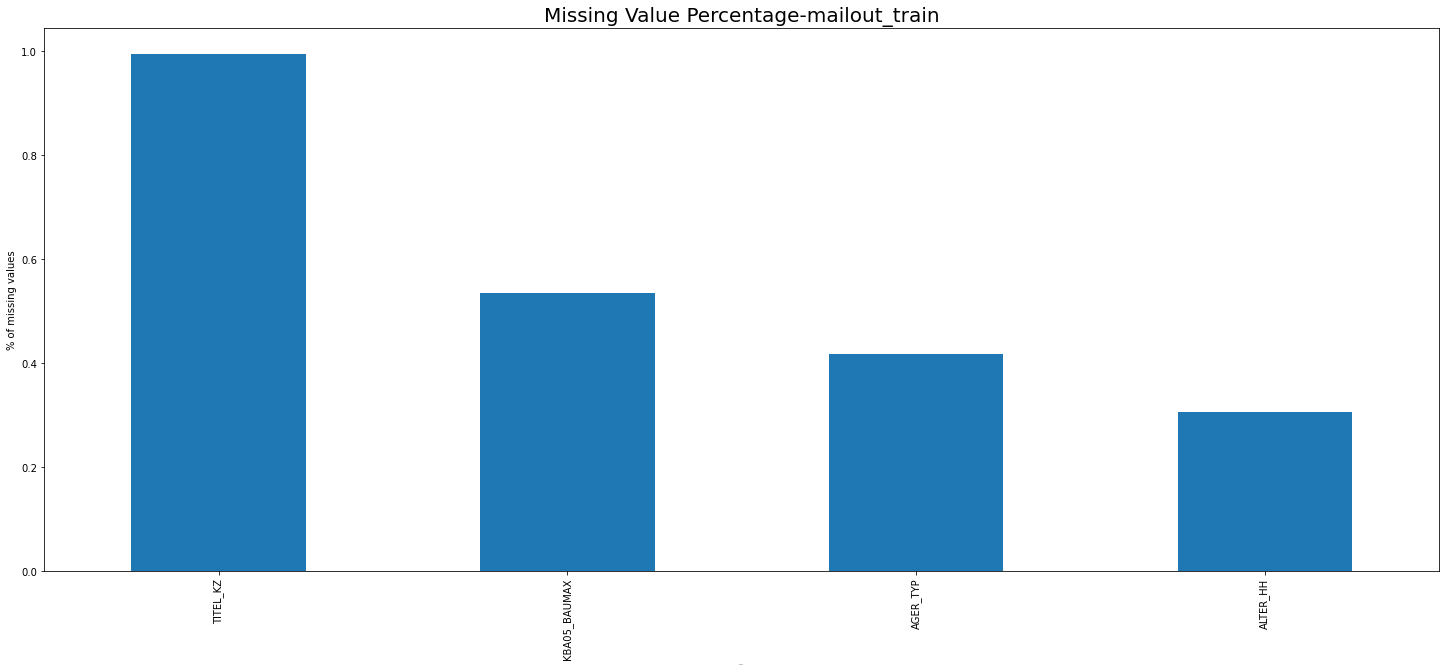

In [11]:
# process the nan values and plot nan value percentage
mailout_clean = nanvalue_fix(mailout_lean, 0.25, 0.3, 'mailout_train')

In [12]:
# train/test data split
X_train, X_test, y_train, y_test = train_test_split(mailout_clean, y, test_size=0.2, random_state=19, stratify=y)

In [13]:
# preprocess the data 
X_train_scaled = preprocess(X_train)
X_test_scaled = preprocess(X_test)

In [17]:
# get the ratio of negative and positive cases, will be used in the scale_pos_weight in XGBoosting
count = Counter(y_train)
count[0]/count[1]

79.67840375586854

#### Due to highly unbalanced class, class_weight='balanced' is specified

In [25]:
# classifiers
clfs = {'logistic regression': LogisticRegression(random_state=19, class_weight='balanced'),
        'decision tree': DecisionTreeClassifier(random_state=19, class_weight='balanced'),
        'random forest': RandomForestClassifier(random_state=19, class_weight='balanced'),
        'XGB': XGBClassifier(random_state=19),
        'SVC': SVC(random_state=19, class_weight='balanced')}

In [26]:
# parameters for each classifier
grid_param_class = {'logistic regression': {'penalty': ['l1'],
                                            'C': [1.0, 0.1, 0.01, 0.001],
                                            'solver': ['liblinear']},
                    'random forest': {'criterion': ['gini', 'entropy'],
                                      'n_estimators' : list(range(70,170,30)),
                                     'max_features': ['auto', 'sqrt'],
                                     'max_depth': [5, 10]},
                    'SVC': {'kernel':['sigmoid', 'linear'],
                            'C': [1],
                            'gamma':[0.001]},
                    'XGB': {'learning_rate': [0.01, 0.001],         
                            'n_estimators' : list(range(120,181,20)),
                            'scale_pos_weight': [5.33, 20, 50.96, count[0]/count[1]]},
                   'decision tree': {'criterion': ['gini', 'entropy'],
                                      'splitter': ['best', 'random'],
                                     'max_features': ['auto', 'sqrt'],
                                     'max_depth': [5, 10, 13],
                                     'min_samples_split': [8, 9, 10, 11, 12, 20],
                                     'min_samples_leaf': [0.1, 0.5, 1, 2, 5]}}

In [27]:
# use GridSearch to find the best parameters for each classifier. 
# print roc, f1 and average precision scores for train/test data
for clf in clfs.keys():
    print('\nClassifier:{0}'.format(clf))
    
    gs = GridSearchCV(clfs[clf], grid_param_class[clf], scoring='roc_auc',
                      cv=StratifiedKFold(), n_jobs=-1, verbose=3)
    gs.fit(X_train_scaled,y_train)
    y_train_pred = gs.predict(X_train_scaled)
    
    print('Best params: {0}'.format(gs.best_params_))
    print('Best training roc-auc score: %.4f' % gs.best_score_)
    print('Best training f1 score: %.4f' % metrics.f1_score(y_train_pred, y_train))
    print('Best training average precision score: %.4f' % metrics.average_precision_score(y_train_pred, y_train))
    
    y_pred = gs.predict(X_test_scaled)
    print('Test set roc score for best params: %.4f ' % metrics.roc_auc_score(y_test, y_pred))
    print('Test set f1 score for best params: %.4f ' % metrics.f1_score(y_test, y_pred))
    print('Test set average precision score for best params: %.4f ' % metrics.average_precision_score(y_test, y_pred))
    


Classifier:logistic regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best training roc-auc score: 0.6381
Best training f1 score: 0.0416
Best training average precision score: 0.3896
Test set roc score for best params: 0.5308 
Test set f1 score for best params: 0.0278 
Test set average precision score for best params: 0.0132 

Classifier:decision tree
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 11, 'splitter': 'random'}
Best training roc-auc score: 0.5878
Best training f1 score: 0.0638
Best training average precision score: 0.2876
Test set roc score for best params: 0.5478 
Test set f1 score for best params: 0.0318 
Test set average precision score for best params: 0.0139 

Classifier:random forest
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'learning_rate': 0.01, 'n_estimators': 180, 'scale_pos_weight': 5.33}
Best training roc-auc score: 0.6177
Best training f1 score: 0.0767
Best training average precision score: 0.0399
Test set roc score for best params: 0.4999 
Test set f1 score for best params: 0.0000 
Test set average precision score for best params: 0.0123 

Classifier:SVC
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best training roc-auc score: 0.6131
Best training f1 score: 0.0459
Best training average precision score: 0.3425
Test set roc score for best params: 0.5266 
Test set f1 score for best params: 0.0275 
Test set aver

#### Since class is highly unbalanced, roc-auc score is used to measure the performance. Based on ROC-AUC, Logistic Regression classifier would be used with parameters {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [55]:
classifier = LogisticRegression(random_state= 19, class_weight='balanced', 
                                 C= 0.01, penalty= 'l1', solver = 'liblinear')
classifier.fit(X_train_scaled, y_train)
y_train_pred = classifier.predict(X_train_scaled)
y_test_pred = classifier.predict(X_test_scaled)

print('training set roc score: %.4f ' % metrics.roc_auc_score(y_train, y_train_pred))
print('training set f1 score: %.4f ' % metrics.f1_score(y_train, y_train_pred))

print('Test set roc score: %.4f ' % metrics.roc_auc_score(y_test, y_test_pred))
print('Test set f1 score: %.4f ' % metrics.f1_score(y_test, y_test_pred))

training set roc score: 0.6421 
training set f1 score: 0.0416 
Test set roc score: 0.5308 
Test set f1 score: 0.0278 


#### The training set roc score is 0.6421. The test set roc score is 0.5308, which is not so high but still better than the threshold 0.5. Accuracy score is not referenced here due to class imbalancement.

In [56]:
# save the model
classifier_file = 'C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/final_model.sav'
pickle.dump(classifier, open(classifier_file, 'wb'))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [32]:
mailout_test = pd.read_csv('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/mailout_test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [33]:
#drop columns and replace mising values
mailout_test_lean = replacenan_lean(mailout_test)

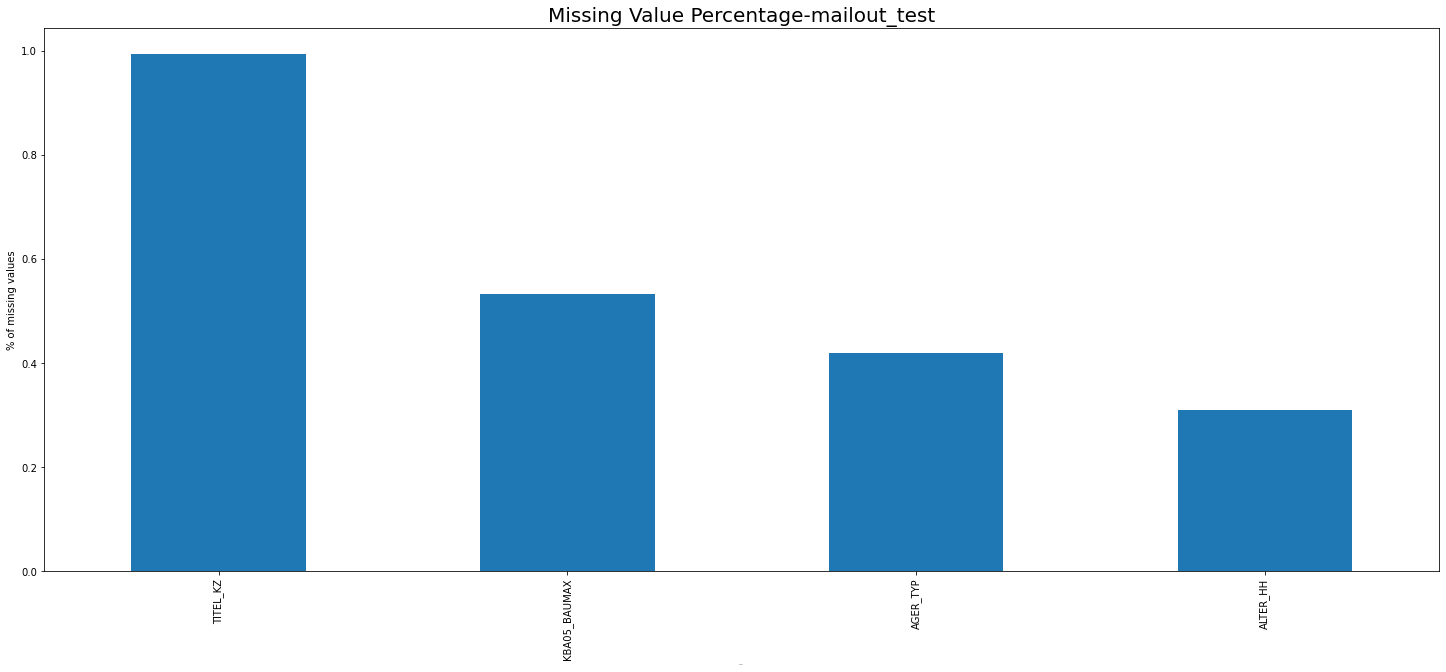

In [34]:
# process the nan values of data and plot nan value percentage
mailout_test_clean = nanvalue_fix(mailout_test_lean, 0.25, 0.3, 'mailout_test')

In [58]:
# preprocess the data
X_predict_scaled = preprocess(mailout_test_clean)
# get the probability
y_predict_prob = classifier.predict_proba(X_predict_scaled)

In [59]:
# combine result with id number
mailout_test_final = pd.concat([mailout_test[['LNR']], pd.DataFrame(y_predict_prob[:, 1], columns = ['RESPONSE'])], axis=1)

In [60]:
mailout_test_final.head(5)

,LNR,RESPONSE
0,1754,0.389889
1,1770,0.543911
2,1465,0.232459
3,1470,0.222735
4,1478,0.351211


In [61]:
mailout_test_final.to_csv('C:/Users/summe/OneDrive/Documents/pj/Udacity nd/capstone/mailout_test_final.csv', index=False)